In [1]:
import random

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
import torch
import torchvision

In [5]:
from torch import nn
from torchvision import datasets, transforms

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
# Device configuration:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
transform = transforms.Compose([
    # Convert the images from PIL format to tensors;
    # and scale the pixel values from [0, 255] to [0, 1]
    transforms.ToTensor(),
    # Normalize the images using the mean and standard deviation of the MNIST dataset.
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
trn_data = datasets.MNIST(
    root= 'data',
    train= True,
    download= True,
    transform= transform
)

tst_data = datasets.MNIST(
    root= 'data',
    train= False,
    download= True,
    transform= transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5383486.23it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 155198.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 500913.54it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7788441.85it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [10]:
print(f'Training data contains {len(trn_data.data)} samples.')
print(f'Test data contains {len(tst_data.data)} samples.')

Training data contains 60000 samples.
Test data contains 10000 samples.


In [11]:
def show_images(dataset, n=5):
    cols = 5
    rows = (n + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i in range(n):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(n, rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


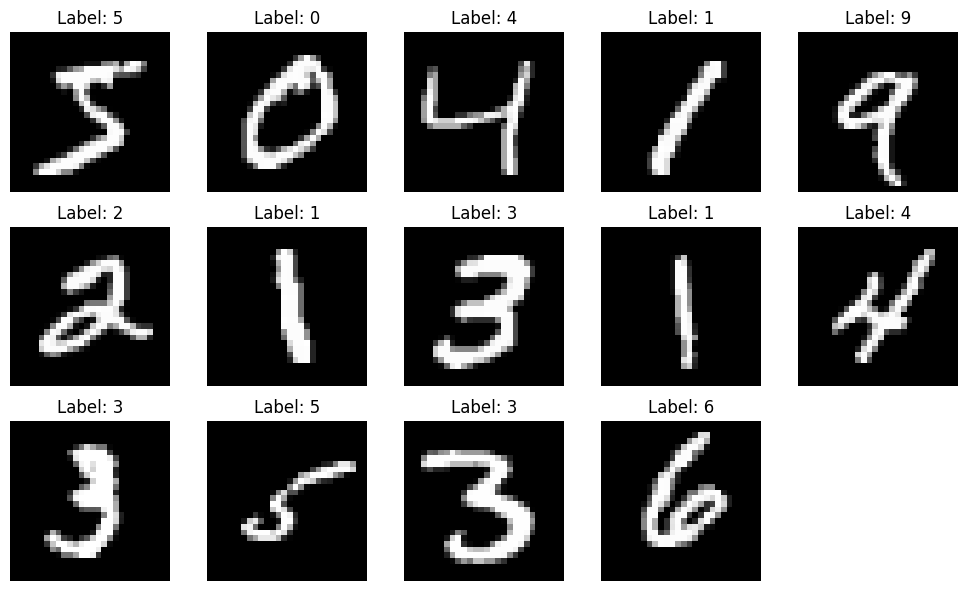

In [12]:
show_images(trn_data, 14)

In [13]:
BATCH_SIZE = 32
trn_loader = DataLoader(trn_data, batch_size= BATCH_SIZE, shuffle= True)
tst_loader = DataLoader(tst_data, batch_size= BATCH_SIZE, shuffle= False)

In [14]:
trn_loader.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [15]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) # 10 digits
        self.dropout = nn.Dropout(.33)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x) # kill 1/3 of the weights
        x = torch.relu(self.fc2(x))
        x = self.dropout(x) # kill 1/3 of the weights
        return torch.softmax(self.fc3(x), dim= 1) # return probability

In [16]:
def train_model(model, loader_trn, loader_tst, criterion, optimizer, epochs):
    model.train()
    losses_trn, losses_tst = [], []
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        for images, labels in loader_trn:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        this_loss = running_loss / len(loader_trn)
        losses_trn.append(this_loss)

        model.eval()
        running_loss_tst = 0.0
        with torch.inference_mode():
            for images, labels in loader_tst:
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                loss = criterion(preds, labels)
                running_loss_tst += loss.item()

            this_loss_tst = running_loss_tst / len(loader_tst)
            losses_tst.append(this_loss_tst)

        print(f'Epoch [{epoch}/{epochs}] => Trn Loss: {this_loss:.4f} | Tst Loss: {this_loss_tst:.4f}')
    return losses_trn, losses_tst

In [17]:
def evaluate_and_get_misclassified(model, data_loader):
    model.eval()
    correct, total = 0, 0
    misclassified_images = []
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            misclassified_images.extend([(img.cpu(), label.cpu(), pred.cpu()) for img, label, pred in zip(images, labels, preds) if label != pred])
    acc = correct / total
    print(f'Accuracy: {acc*100:.2f}%')
    return misclassified_images

In [18]:
def plot_confusion_matrix(model, data_loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize= (10, 8))
    sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues', xticklabels= range(10), yticklabels= range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [19]:
def plot_misclassified(misclassified, n= 5):
    """
    Plot misclassified examples
    """
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize= (12, 2 * rows))
    axes = axes.flatten()
    images_labels_preds = random.sample(misclassified, len(misclassified))
    for i in range(n):
        img, label, pred = images_labels_preds[i]
        img = img.squeeze().numpy()
        axes[i].imshow(img, cmap= 'gray')
        axes[i].set_title(f'True: {label}, Pred: {pred}')
        axes[i].axis(False)
    for i in range(n, rows * cols):
        axes[i].axis(False)

    plt.tight_layout()
    plt.show()

In [20]:
# Initialize model, criterion, optimizer & learning rate scheduler.
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= .001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma= .1)

In [21]:
# Train the model:
EPOCHS = 5
trn_losses, tst_losses = train_model(model, trn_loader, tst_loader, criterion, optimizer, EPOCHS)

Epoch [1/5] => Trn Loss: 1.6092 | Tst Loss: 1.5257
Epoch [2/5] => Trn Loss: 1.5172 | Tst Loss: 1.5050
Epoch [3/5] => Trn Loss: 1.5053 | Tst Loss: 1.5178
Epoch [4/5] => Trn Loss: 1.4987 | Tst Loss: 1.4973
Epoch [5/5] => Trn Loss: 1.4958 | Tst Loss: 1.4989


In [22]:
print('Evaluate model on training data:')
_ = evaluate_and_get_misclassified(model, trn_loader)

Evaluate model on training data:
Accuracy: 96.90%


In [23]:
print('Evaluate model on test data:')
missed_images_tst = evaluate_and_get_misclassified(model, tst_loader)

Evaluate model on test data:
Accuracy: 96.26%


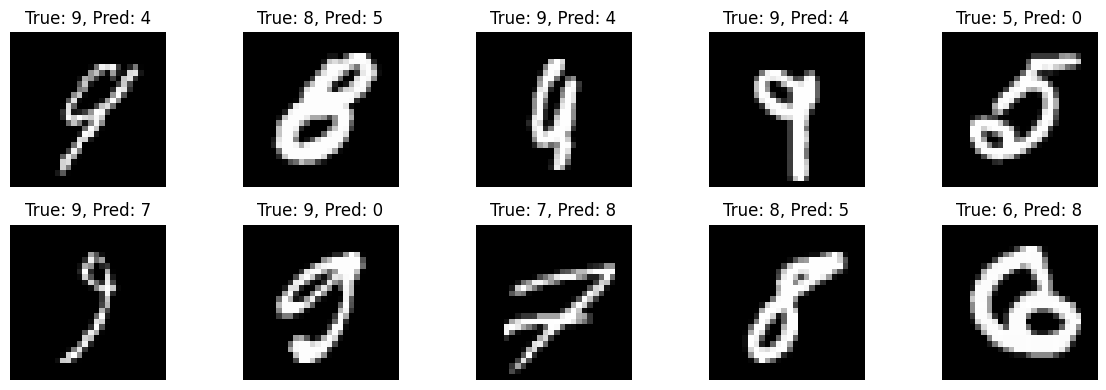

In [24]:
# Although some examples are tough to recognize, few mistakes are really not that hard.
plot_misclassified(missed_images_tst, 10)

Confusion Matrix on Test Data:


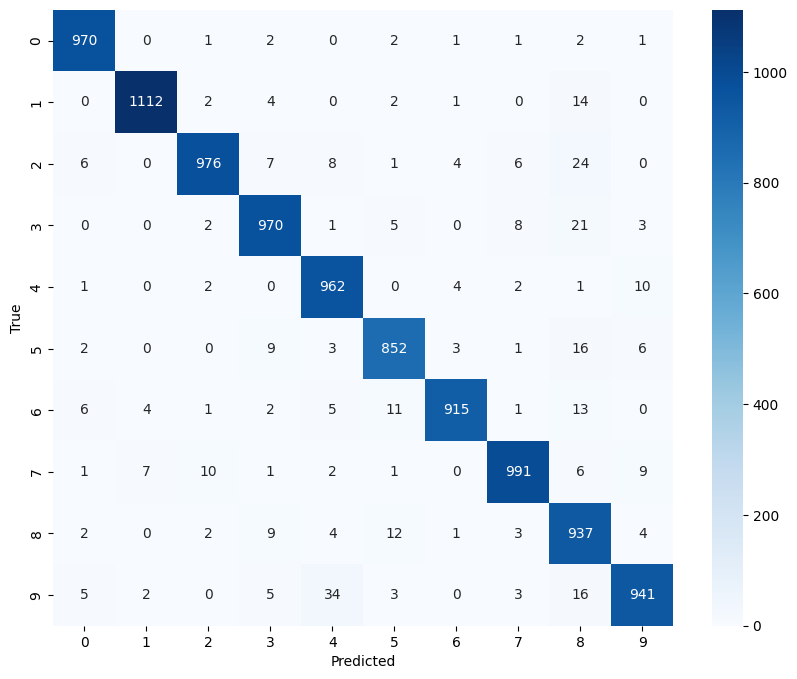

In [25]:
print('Confusion Matrix on Test Data:')
plot_confusion_matrix(model, tst_loader)

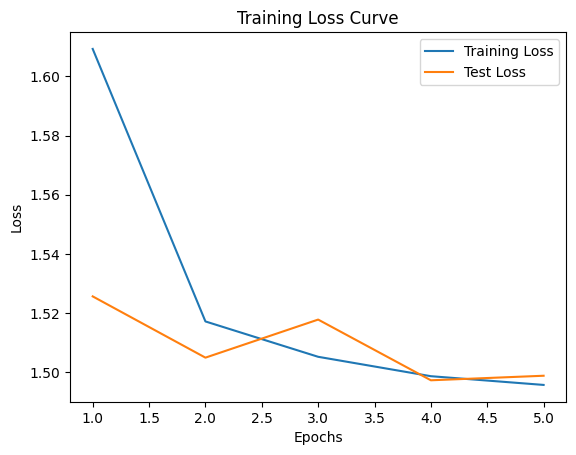

In [26]:
# Show the validation curve:
plt.plot(range(1, EPOCHS+1), trn_losses, label= 'Training Loss')
plt.plot(range(1, EPOCHS+1), tst_losses, label= 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [27]:
# Save the model:
torch.save(model.state_dict(), 'mnist_model.ph')